<a href="https://colab.research.google.com/github/kemoch/Whats-in-the-fridge/blob/master/WhatsInTheFridge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What's in the fridge?

by: Kevin Mochi

Inspired by Francisco Ingham, Jeremy Howard and [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)

In [0]:
  !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from fastai.vision import *

## Get a list of URLs

### Search and scroll

I have searched for some courgettes, onions and tomatoes images from [Google Images](http://images.google.com)

### Download into file

I have run this Javascript code in the browser to save the URLs of all the images I wanted for my dataset.

```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

### Create directory and upload urls file into your server

Run these steps multiple times to create different labels.

In [0]:
folder = 'courgette'
file = 'urls_courgette.txt'

In [0]:
folder = 'tomato'
file = 'urls_tomato.txt'

In [0]:
folder = 'onion'
file = 'urls_onion.txt'

running this cell once per each category.

In [0]:
path = Path('gdrive/My Drive/vegetables')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [0]:
path.ls()

[PosixPath('gdrive/My Drive/vegetables/courgette')]

In [0]:
!ls "/content/gdrive/My Drive/vegetables"

courgette  urls_courgette.txt  urls_onion.txt  urls_tomato.txt


Finally, I uploaded the urls file.

## Download images

I have used a fast.ai  function to download the images from their respective urls running it once for every category.

In [0]:
classes = ['courgette','tomato','onion']

In [0]:
download_images(path/file, dest, max_pics=200, max_workers=0)

In [0]:
# If you have problems download, try with `max_workers=0` to see exceptions:
download_images(path/file, dest, max_pics=20, max_workers=0)

Removing any images that can't be opened:

In [0]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

## View data

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [0]:
# If you already cleaned your data, run this cell instead of the one before
# np.random.seed(42)
# data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
#         ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [0]:
data.classes

['courgette', 'onion', 'tomato']

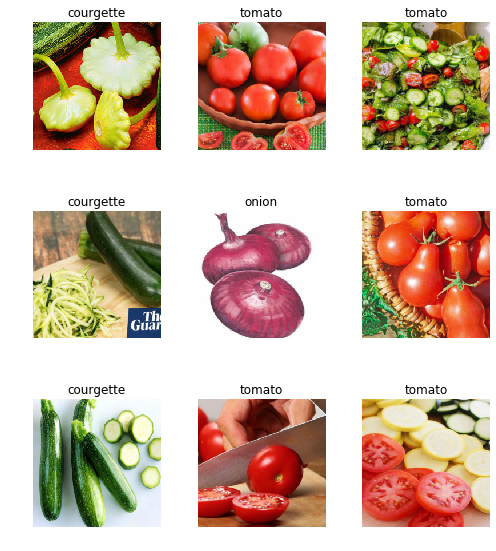

In [0]:
data.show_batch(rows=3, figsize=(7,8))

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['courgette', 'onion', 'tomato'], 3, 305, 76)

## Train model

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 143583224.19it/s]


In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.151960,0.401163,0.157895,01:47
1,0.688343,0.128993,0.052632,01:47
2,0.491986,0.099752,0.039474,01:47
3,0.378907,0.092480,0.026316,01:46


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find(start_lr=1e-5, end_lr=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [0]:
# If the plot is not showing try to give a start and end learning rate# learn.lr_find(start_lr=1e-5, end_lr=1e-1)learn.recorder.plot()

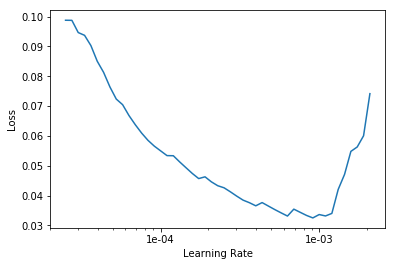

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.066699,0.086146,0.026316,02:27
1,0.054309,0.095730,0.026316,02:26


In [0]:
learn.save('stage-2')

## Interpretation

In [0]:
learn.load('stage-2');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

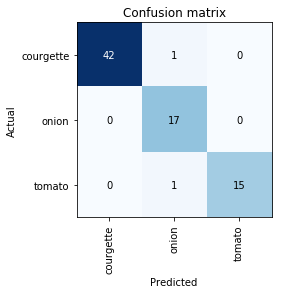

In [0]:
interp.plot_confusion_matrix()

## Putting the model in production

Export the content of the `Learner` object for production:

In [0]:
learn.export()

Without the need to train in real time and the modest scale, I have used a CPU for inference.

In [0]:
defaults.device = torch.device('cpu')

In [0]:
from PIL import Image

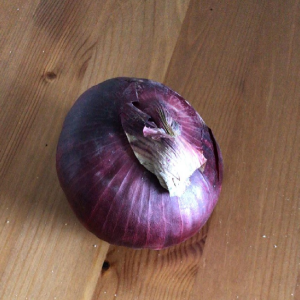

In [0]:
img = open_image(path/'IMG2.jpg');
img.resize(300,);
img

In [0]:
learn = load_learner(path)

In [0]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category onion

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)